## Frequency-Domain Analysis of a Linear Single-Track Vehicle Model

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmath
me.init_vprinting(use_latex = 'mathjax')

The single-track vehicle model schematic is on the main page of the repository.

The first-order equations of motions, as described in the time-domain analysis notebook, are [Pacejka, 2012]
$$ m\dot{v} + \frac{1}{V}(C_f + C_r)v + \{mu + \frac{1}{V}(aC_f - bC_r)\}r = C_f \delta $$
$$ I\dot{r} + \frac{1}{V}(a^2C_f - b^2C_r)r + \frac{1}{V}(aC_f - bC_r)v = aC_f\delta $$

In order to perform the frequency-response analysis, we transform the above equations into one, second-order equation [Pcejka, 2012]:

$$ Imu^2 \ddot{r} + \{I(C_f+ C_r) + m(a^2C_f + bC_r)\}u\dot{r} + \{C_fC_rl^2 - mu^2(aC_f - bC_r)\}r = mu^2aC_f\dot{\delta} + C_fC_r l \delta u$$ 

### Yaw Velocity Response to Steer Angle:
To get the transfer function for the yaw velocity response, we rewrite the above equation in the form below:

$$ M\ddot{r} + D_1\dot{r} + K_1 = D_2\dot{\delta} + K_2 \delta $$ 

taking the Laplace transform and re-arranging the terms, we can get the transform function for the yaw velocity response to steer angle as:

$$ \frac{r(s)}{\delta(s)} = \frac{D_2 s + K_2}{Ms^2 + D_1s + K_1} $$

where

$ s = j\omega $ and $\omega$ is the frequency in [rad]

In [2]:
# Defining the parameters symbolically
#------------------------------------
m, I     = sm.symbols('m, I')           # mass and moment of inertia (Izz) of the vehicle
v, u, V  = sm.symbols('v, u, V')        # lateral, longitudinal, and total velocity of the vehicle
a, b, l  = sm.symbols('a, b, l')        # distances a, b, and l on the figure
g        = sm.symbols('g')              # gravitational constant
Cf, Cr   = sm.symbols('C_f, C_r')       # conering stiffness of the front and rear axles
delta    = me.dynamicsymbols('delta')   # road steer angle
r        = me.dynamicsymbols('r')       # yaw velocity
omega    = sm.symbols('omega')          # frequency

p_veh    = sm.Matrix([m, I, a, b, l, Cf, Cr])

t        = me.dynamicsymbols._t

In [3]:
# Defining the terms in the transfer function
# -------------------------------------------
M_term  = I*m*V**2
D1_term = (I*(Cf+Cr)+ m*(a**2*Cf + b**2*Cr))*V
K1_term = Cf*Cr*l**2 - m*V**2*(a*Cf - b*Cr)
D2_term = m*V**2*a*Cf
K2_term = Cf*Cr*l*V
S_term  = omega*1j

In [4]:
# Yaw response transfer function
# -----------------------------
yaw_resp = (D2_term*S_term+K2_term )/(M_term*S_term**2+D1_term*S_term+K1_term)

eval_yaw_resp = sm.lambdify((p_veh, V, omega), yaw_resp)

yaw_resp, yaw_resp.free_symbols

⎛                                                      2                      
⎜                              C_f⋅Cᵣ⋅V⋅l + 1.0⋅ⅈ⋅C_f⋅V ⋅a⋅m⋅ω                
⎜─────────────────────────────────────────────────────────────────────────────
⎜        2      2    2    2                              ⎛                 ⎛  
⎝C_f⋅Cᵣ⋅l  - I⋅V ⋅m⋅ω  - V ⋅m⋅(C_f⋅a - Cᵣ⋅b) + 1.0⋅ⅈ⋅V⋅ω⋅⎝I⋅(C_f + Cᵣ) + m⋅⎝C_

                                              ⎞
                                              ⎟
──────────────, {C_f, Cᵣ, I, V, a, b, l, m, ω}⎟
   2       2⎞⎞                                ⎟
f⋅a  + Cᵣ⋅b ⎠⎠                                ⎠

### Lateral Acceleration Response to Steer Angle
To obtain the transfer function for the lateral acceleration response, we use 
$$ a_y = \dot{v} + Vr $$
and by taking the Laplace transform and re-arranging the terms we get to:
$$ \frac{a_r(s)}{\delta(s)} = \frac{VC_fs}{T_1} + (-\frac{T_2s}{T_1}+V)\frac{r(s)}{\delta(s)} $$
the terms related to $T_1$ and $T_2$ are defined below: 

In [5]:
# Defining the terms in the lateral acceleration transfer function
# ----------------------------------------------------------------
T1_term = m*S_term*V + Cf + Cr
T2_term = a*Cf - b*Cr + m*V**2

In [6]:
# Lateral acceleration response transfer function
# -----------------------------------------------
lat_acc_resp = V*S_term*Cf/T1_term + yaw_resp * (-S_term*T2_term/T1_term + V)

eval_lat_acc_resp = sm.lambdify((p_veh, V, omega), lat_acc_resp)

lat_acc_resp, lat_acc_resp.free_symbols

⎛                                      ⎛        ⎛                2  ⎞⎞        
⎜                                      ⎜    ⅈ⋅ω⋅⎝C_f⋅a - Cᵣ⋅b + V ⋅m⎠⎟ ⎛      
⎜                                      ⎜V - ─────────────────────────⎟⋅⎝C_f⋅Cᵣ
⎜    1.0⋅ⅈ⋅C_f⋅V⋅ω                     ⎝      C_f + Cᵣ + 1.0⋅ⅈ⋅V⋅m⋅ω ⎠        
⎜────────────────────── + ────────────────────────────────────────────────────
⎜C_f + Cᵣ + 1.0⋅ⅈ⋅V⋅m⋅ω           2      2    2    2                          
⎝                         C_f⋅Cᵣ⋅l  - I⋅V ⋅m⋅ω  - V ⋅m⋅(C_f⋅a - Cᵣ⋅b) + 1.0⋅ⅈ⋅

                                                                       ⎞
                  2      ⎞                                             ⎟
⋅V⋅l + 1.0⋅ⅈ⋅C_f⋅V ⋅a⋅m⋅ω⎠                                             ⎟
                                                                       ⎟
───────────────────────────────────────, {C_f, Cᵣ, I, V, a, b, l, m, ω}⎟
    ⎛                 ⎛     2       2⎞⎞                                ⎟
V⋅ω⋅⎝I⋅(

In [7]:
# Defining the parameters of the vehicle and frequency response analysis
# ----------------------------------------------------------------------
# p_veh    = sm.Matrix([m, I, a, b, l, Cf, Cr])
p_veh_vals = np.array([1600,          # [kg]
                       1600*1.5**2,   # [kg.m^2]
                       1.4,           # [m] 
                       1.6,           # [m]
                       3,             # [m]
                       60000,         # [N/rad]
                       60000          # [N/rad]
                      ])

V_veh_vals = [20, 40, 60] # [m/s]
V_labels   = ['V = 20 m/s', 'V = 40 m/s', 'V = 60 m/s']
omega_vals = np.linspace(0.6, 86, 500) # [rad/s]
f_vals     = omega_vals/(2*np.pi) # [rad/s] -> [Hz]

# Pre-allocating arrays for the responses
# --------------------------------------
yaw_resp_vals = np.empty((len(omega_vals), len(V_veh_vals)), dtype = complex)
yaw_gain      = np.empty((len(omega_vals), len(V_veh_vals)))
yaw_phase     = np.empty((len(omega_vals), len(V_veh_vals)))

lat_acc_resp_vals = np.empty((len(omega_vals), len(V_veh_vals)), dtype = complex)
lat_acc_gain      = np.empty((len(omega_vals), len(V_veh_vals)))
lat_acc_phase     = np.empty((len(omega_vals), len(V_veh_vals)))

# Obtaining the responses
#-------------------------
for i in range(len(V_veh_vals)):
    yaw_resp_vals[:,i] = eval_yaw_resp(p_veh_vals, V_veh_vals[i], omega_vals)
    yaw_gain[:,i]      = np.abs(yaw_resp_vals[:,i])
    yaw_phase[:,i]     = np.array([cmath.phase(z)*180/np.pi for z in yaw_resp_vals[:,i]]) # [rad]-> [deg]

for i in range(len(V_veh_vals)):
    lat_acc_resp_vals[:,i] = eval_lat_acc_resp(p_veh_vals, V_veh_vals[i], omega_vals)*np.pi/180 # -> m/s^2/rad -> m/s^2/deg
    lat_acc_gain[:,i]      = np.abs(lat_acc_resp_vals[:,i])
    lat_acc_phase[:,i]     = np.array([cmath.phase(z)*180/np.pi for z in lat_acc_resp_vals[:,i]]) # [rad]-> [deg]
    

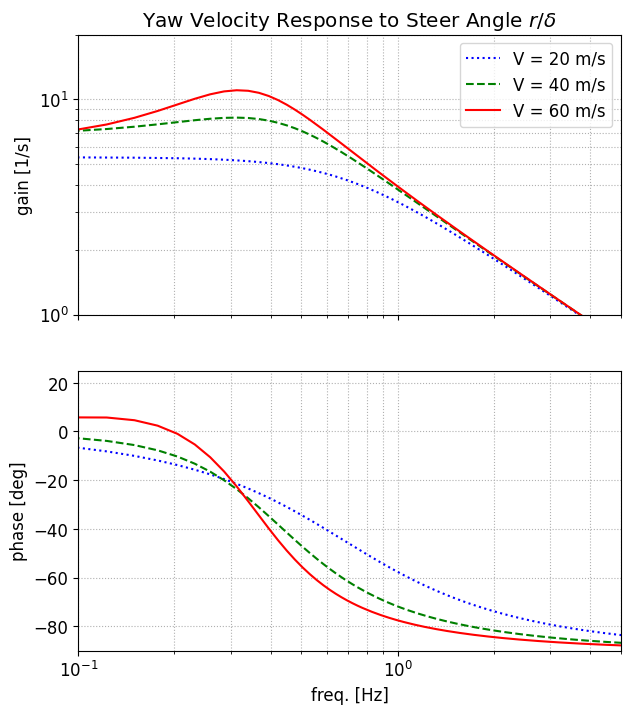

In [10]:
# Plotting the responses for yaw velocity
# --------------------------------------
fig, ax = plt.subplots(2,1, sharex=True, figsize = (7,8))
line_styles = [':', '--', '-']
colors = ['blue','green', 'red']

for i in range(len(V_veh_vals)):
    ax[0].loglog(f_vals, yaw_gain[:,i], label = V_labels[i], ls = line_styles[i], color = colors[i])
ax[0].set_ylim([1, 20])
ax[0].set_xlim([0.1, 5])
ax[0].set_ylabel('gain [1/s]')
ax[0].set_title('Yaw Velocity Response to Steer Angle $r/\\delta$')
ax[0].grid(True, which="both", ls=":")
ax[0].legend()

for i in range(len(V_veh_vals)):
    ax[1].semilogx(f_vals, yaw_phase[:,i], label = V_labels[i], ls = line_styles[i], color = colors[i]);
ax[1].set_xlim([0.1, 5])
ax[1].set_ylim([-90, 25])
ax[1].set_xlabel('freq. [Hz]')
ax[1].set_ylabel('phase [deg]');
ax[1].grid(True, which="both", ls=":")

mpl.rcParams['font.size'] = 14

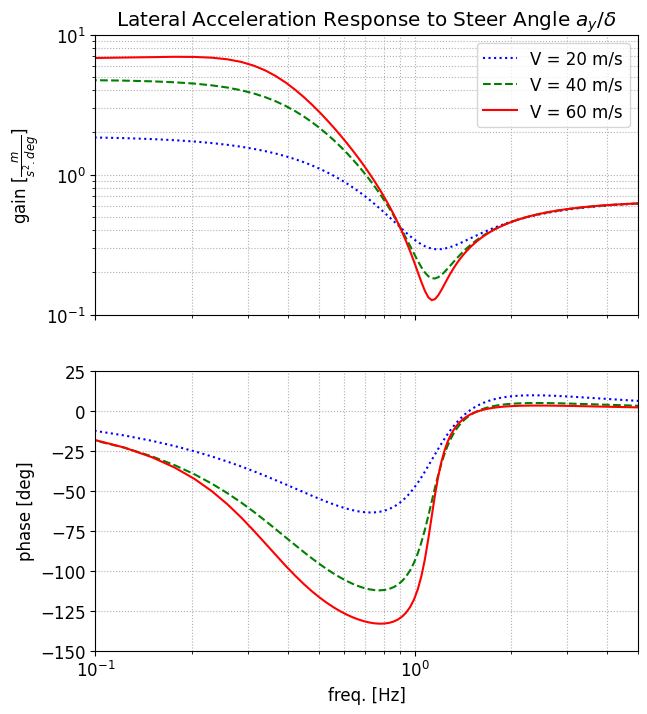

In [9]:
# Plotting the responses for lateral acceleration
# -----------------------------------------------
fig, ax = plt.subplots(2,1, sharex=True, figsize = (7,8))
line_styles = [':', '--', '-']
colors = ['blue','green', 'red']

for i in range(len(V_veh_vals)):
    ax[0].loglog(f_vals, lat_acc_gain[:,i], label = V_labels[i], ls = line_styles[i], color = colors[i])
ax[0].set_ylim([0.1, 10])
ax[0].set_xlim([0.1, 5])    
ax[0].set_ylabel('gain [$\\frac{m}{s^2.deg}$]')
ax[0].set_title('Lateral Acceleration Response to Steer Angle $a_y/\\delta$')
ax[0].legend()
ax[0].grid(True, which="both", ls=":")


for i in range(len(V_veh_vals)):
    ax[1].semilogx(f_vals, lat_acc_phase[:,i], label = V_labels[i], ls = line_styles[i], color = colors[i]);
ax[1].set_xlim([0.1, 5])
ax[1].set_ylim([-150, 25])    
ax[1].set_xlabel('freq. [Hz]')
ax[1].set_ylabel('phase [deg]');
ax[1].grid(True, which="both", ls=":")


mpl.rcParams['font.size'] = 12

### Note:
The results in this notebook were verified with the ones in [Pacejka, 2012].

### References
- Pacejka, H. (2012). Tire and vehicle dynamics. Elsevier.